In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import utils

In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.2.2+cu121
12.1
True
cuda


In [3]:
CUDA = True
DATA_PATH = './img_align_celeba'
OUT_PATH = 'output'
LOG_FILE = os.path.join(OUT_PATH, 'log.txt')
BATCH_SIZE = 128
IMAGE_CHANNEL = 3
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 5
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

In [5]:
utils.clear_folder(OUT_PATH)
print("Logging to {}\n".format(LOG_FILE))
sys.stdout = utils.StdOut(LOG_FILE)
CUDA = CUDA and torch.cuda.is_available()
if seed is None:
  seed = np.random.randint(1, 10000)
print("Random seed: ", seed)
np.random.seed(seed)
if CUDA:
  torch.cuda.manual_seed(seed)
cudnn.benchmark = True
device = torch.device("cuda:0" if CUDA else "cpu")

Logging to output\log.txt

Random seed:  1


# Weights initialization

In [4]:
def weights_init(m):
      """
      Here we initialize the convolution kernels based on the Gaussian distribution with a mean of 0 and a standard deviation of 0.02.
      We also initialize the affine parameters(scaling factors) in batch
      """
      classname =  m.__class__.__name__
      if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
      elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Generator network

In [5]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main  = nn.Sequential(
        #1st layer
        nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, kernel_size = 4, stride = 1, padding = 0, bias = False), # (100, 512, 4, 1, 0, False)
        nn.BatchNorm2d(G_HIDDEN * 8),
        nn.ReLU(True),
        #2nd layer
        nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, kernel_size = 4, stride = 2, padding = 1, bias = False), # (512, 256, 4, 2, 1, False)
        nn.BatchNorm2d(G_HIDDEN * 4),
        nn.ReLU(True),
        #3rd layer
        nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, kernel_size = 4, stride = 2, padding = 1, bias = False), # (256, 128, 4, 2, 1, False)
        nn.BatchNorm2d(G_HIDDEN * 2),
        nn.ReLU(True),
        #4th layer
        nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, kernel_size = 4, stride = 2, padding = 1, bias = False), # (128, 64, 4, 2, 1, False)
        nn.BatchNorm2d(G_HIDDEN),
        nn.ReLU(True),
        #output layer
        nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, kernel_size = 4, stride = 2, padding = 1, bias = False), # (64, 1, 4, 2, 1, False)
        nn.Tanh()
    )
  def forward(self, input):
    return self.main(input)

In [8]:
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator network

In [9]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        #1st layer
        nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias = False), # (1, 64, 4, 2, 1, False)
        nn.LeakyReLU(0.2, inplace = True),
        #2nd layer
        nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias = False), # (64, 128, 4, 2, 1, False)
        nn.BatchNorm2d(D_HIDDEN * 2),
        nn.LeakyReLU(0.2, inplace = True),
        #3rd layer
        nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias = False), # (128, 256, 4, 2, 1, False)
        nn.BatchNorm2d(D_HIDDEN * 4),
        nn.LeakyReLU(0.2, inplace = True),
        #4th layer
        nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias = False), # (256, 512, 4, 2, 1, False)
        nn.BatchNorm2d(D_HIDDEN * 8),
        nn.LeakyReLU(0.2, inplace = True),
        #output layer
        nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias = False), # (512, 1, 4, 1, 0, False)
        nn.Sigmoid()
    )
  def forward(self, input):
    return self.main(input).view(-1, 1).squeeze(1)

In [10]:
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

# Loss function

In [11]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (0.5, 0.999))

# Load the CelebA dataset to GPU

In [12]:
dataset = dset.ImageFolder(root = DATA_PATH, transform = transforms.Compose([
    transforms.Resize(X_DIM),
    transforms.CenterCrop(X_DIM),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]))

assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4, pin_memory = True)

# Training

In [13]:
"""
1. Train the discriminator with the real data and recognize it as real.
2. Train the discriminator with the fake data and recognize it as fake.
3. Train the generator with the fake data and recognize it as real.

The first two steps let the discriminator learn how to tell the difference between real data and fake data.
The third step teaches the generator how to confuse the discriminator with generated samples.
"""
d_history = []
g_history = []
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device = device)
for epoch in range(EPOCH_NUM):
  for i, data in enumerate(dataloader):
    x_real = data[0].to(device)
    real_label = torch.full((x_real.size(0),), REAL_LABEL, device = device)
    fake_label = torch.full((x_real.size(0),), FAKE_LABEL, device = device)

    #Update D with real data
    netD.zero_grad()
    y_real = netD(x_real)
    loss_D_real = criterion(y_real, real_label.float())
    loss_D_real.backward()
    #Update D with fake data
    z_noise = torch.randn(x_real.size(0), Z_DIM, 1, 1, device = device)
    x_fake = netG(z_noise)
    y_fake = netD(x_fake.detach())
    loss_D_fake = criterion(y_fake, fake_label.float())
    loss_D_fake.backward()
    optimizerD.step()
    #Update G with fake data
    netG.zero_grad()
    y_fake_r = netD(x_fake)
    loss_G = criterion(y_fake_r, real_label.float())
    loss_G.backward()
    optimizerG.step()

    if i % 100 == 0:
      print('Epoch {} [{}/{}] loss_D_real: {:.4f} loss_D_fake: {:.4f} loss_G:  {:.4f}'.format(
          epoch, i, len(dataloader), loss_D_real.mean().item(), loss_D_fake.mean().item(), loss_G.mean().item()
          ))
      vutils.save_image(x_real, os.path.join(OUT_PATH, 'real_samples.png'), normalize = True)
      with torch.no_grad():
        viz_sample = netG(viz_noise)
        vutils.save_image(viz_sample, os.path.join(OUT_PATH, 'fake_samples_{}.png'.format(epoch)), normalize = True)

      # torch.save(netG.state_dict(), os.path.join(OUT_PATH, 'netG_{}.pth'.format(epoch)))
      # torch.save(netD.state_dict(), os.path.join(OUT_PATH, 'netD_{}.pth'.format(epoch)))
  #plot D history
  loss_D = loss_D_real + loss_D_fake
  d_history.append(loss_D.item())
  #plot G history
  g_history.append(loss_G.item())

# Save the generator and discriminator networks

In [14]:
torch.save(netG.state_dict(), os.path.join(OUT_PATH, 'netG_5_epochs.pth'))
torch.save(netD.state_dict(), os.path.join(OUT_PATH, 'netD_5_epochs.pth'))

# Plot the losses

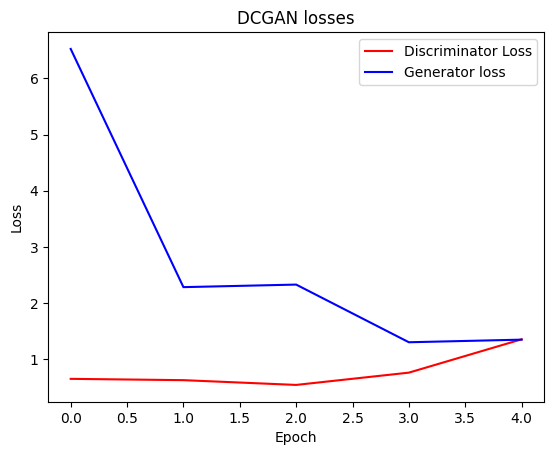

In [16]:
import matplotlib.pyplot as plt
plt.plot(d_history, label='Discriminator Loss', color='red')
plt.plot(g_history, label = 'Generator loss', color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DCGAN losses')
plt.legend()
plt.show()

# Having fun with the Generator

In [6]:
from datetime import datetime
import scipy
from scipy import interpolate
# Load the generator from the saved model
netG = Generator()
netG.load_state_dict(torch.load(os.path.join(OUT_PATH, 'netG_5_epochs.pth')))
netG.to(device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [14]:
"""
0 : creating a random starting tensor
1 : Image interpolation
2 : Semantic vector arithmetic
"""

# Semi refers to just z1 - z2 without the z3

def visualize_gen(VIZ_MODE = 0, BATCH_SIZE = 20, semi = False):
    if VIZ_MODE == 0:
        viz_tensor = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device = device) # Create a starting random tensor
    elif VIZ_MODE == 1:
        load_vector = np.loadtxt('vec_20240329-123635.txt') 
        xp = [0, 1]
        yp = np.vstack([load_vector[9], load_vector[14]]) # Choose two exemplar vectors by stacking these two arrays in sequence vertically
        xvals = np.linspace(0, 1, num = BATCH_SIZE) # Create evenly spaced numbers over a specified interval
        sample = interpolate.interp1d(xp, yp, axis = 0) # scipy interpolation method
        viz_tensor = torch.tensor(sample(xvals).reshape(BATCH_SIZE, Z_DIM, 1, 1), dtype = torch.float32, device = device)
        print(viz_tensor.shape)
    elif VIZ_MODE == 2:
        load_vector = np.loadtxt('vec_20240329-123635.txt')
        z1 = (load_vector[7] + load_vector[15] + load_vector[12]) / 3. # Images 1,7,9 are of smiling women (mean)
        z2 = (load_vector[14] + load_vector[17] + load_vector[5]) / 3. # Images 2,3,5 are of non-smiling women (mean)
        z3 = (load_vector[0] + load_vector[16] + load_vector[13]) / 3. # Images of non-smiling men (mean)
        z_semi = z1 - z2
        z_new = z1 - z2 + z3 # Here we try to subtract the women smiling with the non-smiling to store the "smile" and then add it with the men's vector to try and put a smile on the non-smiling men
        sample = np.zeros(shape = (BATCH_SIZE, Z_DIM))
        sample_semi = np.zeros(shape = (BATCH_SIZE, Z_DIM))
        for i in range(BATCH_SIZE):
            sample[i] = z_new + 0.1 * np.random.normal(-1.0, 1.0, 100) #randomize the generated samples for variety
            sample_semi[i] = z_semi + 0.1 * np.random.normal(-1.0, 1.0, 100)
        viz_tensor = torch.tensor(sample.reshape(BATCH_SIZE, Z_DIM, 1, 1), dtype = torch.float32, device = device)
        viz_tensor_semi = torch.tensor(sample_semi.reshape(BATCH_SIZE, Z_DIM, 1, 1), dtype = torch.float32, device = device)
    
    with torch.no_grad():
        if semi:
            viz_sample_semi = netG(viz_tensor_semi)
            viz_vector_semi = utils.to_np(viz_tensor_semi).reshape(BATCH_SIZE, Z_DIM) # Export torch.Tensor to Numpy array
            cur_time = datetime.now().strftime("%Y%m%d-%H%M%S")
            np.savetxt('vec_semi_{}.txt'.format(cur_time), viz_vector_semi)
            vutils.save_image(viz_sample_semi, 'img_semi_{}.png'.format(cur_time), nrow = BATCH_SIZE, normalize = True)
        viz_sample = netG(viz_tensor)
        viz_vector = utils.to_np(viz_tensor).reshape(BATCH_SIZE, Z_DIM) # Export torch.Tensor to Numpy array
        cur_time = datetime.now().strftime("%Y%m%d-%H%M%S")
        np.savetxt('vec_{}.txt'.format(cur_time), viz_vector)
        vutils.save_image(viz_sample, 'img_{}.png'.format(cur_time), nrow = BATCH_SIZE, normalize = True)

In [70]:
visualize_gen()

In [58]:
# Interpolation
visualize_gen(1)

In [15]:
#Semantic arithmetic
visualize_gen(2, semi = True)